 # Stationary thermal balance of a two-layer corium pool
---

In [136]:
import sympy
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [137]:
from math import pi  
g = 9.81
sigma = 5.67E-08

Set decay power and hemisphere radius

In [138]:
Pres=15E6
R=2

## 1. Oxide pool

Set $\rho^{ox},\lambda^{ox},\nu^{ox},Cp^{ox},\beta^{ox},T_{liq}^{ox},H^{ox}$

In [139]:
oxide = {
      "rho":    8000,
      "lambda": 5,
      "nu":     5E-7,
      "Cp":     500,
      "beta":   1E-4,
      "Tliq":   2900,
      "H":      1.5
    }

Calculate $V^{ox}$, $S_{lat}^{ox}$, $S_{up}^{ox}$

>$V^{ox}=\frac{\pi}{3}\left(H^{ox}\right)^2\left(3R-H^{ox}\right)$

>$S_{lat}^{ox}=2\pi R H^{ox}$

>$S_{up}^{ox}=\pi\left(R^2-\left(R-H^{ox}\right)^2\right)$

In [140]:
V_ox = pi/3*oxide["H"]**2*(3*R-oxide["H"])
Slat_ox=2*pi*R*oxide["H"]
Sup_ox=pi*(R**2-(R-oxide["H"])**2)
print('V_ox={0:e}, Slat_ox={1:e}, Sup_ox={2:e}'.format(V_ox, Slat_ox, Sup_ox))

V_ox=1.060288e+01, Slat_ox=1.884956e+01, Sup_ox=1.178097e+01


Calculate $Ra_i^{ox}$

>$q^{ox} = \frac{P_{res}}{V^{ox}}$

>$\alpha^{ox}=\frac{\lambda^{ox}}{\rho^{ox}Cp^{ox}}$

>$Ra_i^{ox}=\frac{g\left(H^{ox}\right)^5q^{ox}\beta^{ox}}{\lambda^{ox}\nu^{ox}\alpha^{ox}}$

In [141]:
q_ox = Pres / V_ox
print('q_ox={0:e}'.format(q_ox))
oxide["alpha"]=oxide["lambda"]/(oxide["rho"]*oxide["Cp"])
Rai_ox=g*oxide["H"]**5*q_ox*oxide["beta"]/(oxide["lambda"]*oxide["nu"]*oxide["alpha"])
print('Rai_ox={0:e}'.format(Rai_ox))

q_ox=1.414711e+06
Rai_ox=3.372430e+15


Calculate $Nu^{ox}_{lat}$ based on "BALI downward" correlation $Nu^{ox}_{lat}=0.131\left(Ra_i^{ox}\right)^{0.25}\left(\frac{H^{ox}}{R}\right)^{0.19}$

In [142]:
Nulat_ox=0.131*Rai_ox**0.25*(oxide["H"]/R)**0.19
htc = oxide["lambda"]*Nulat_ox/oxide["H"]
print('Nulat_ox={0:e} (htc={1:f})'.format(Nulat_ox,htc))

Nulat_ox=9.451890e+02 (htc=3150.629997)


Calculate $Nu^{ox}_{up}$ based on "BALI upward" correlation $Nu^{ox}_{up}=0.381\left(Ra_i^{ox}\right)^{0.234}$

In [143]:
Nuup_ox=0.381*Rai_ox**0.234
htc = oxide["lambda"]*Nuup_ox/oxide["H"]
print('Nuup_ox={0:e} (htc={1:f})'.format(Nuup_ox,htc))

Nuup_ox=1.638565e+03 (htc=5461.882553)


Calculate $T^{ox}$

>$T^{ox}=T^{ox}_{liq}+P_{res}\frac{H^{ox}}{\lambda^{ox}}\left(Nu_{lat}^{ox}S_{lat}^{ox}+Nu_{up}^{ox}S_{up}^{ox}\right)^{-1}$

In [144]:
T_ox=oxide["Tliq"]+Pres*oxide["H"]/oxide["lambda"]/(Nulat_ox*Slat_ox+Nuup_ox*Sup_ox)
print('T_ox={0:5.1f}'.format(T_ox))

T_ox=3021.2


Calculate $\phi_{lat}^{ox}$ and $\phi_{up}^{ox}$

>$\phi_{\star}^{ox}=\left(\frac{\lambda^{ox}}{H^{ox}}Nu_{\star}^{ox}\right)\left(T^{ox}-T^{ox}_{liq}\right)$

In [145]:
philat_ox=oxide["lambda"]/oxide["H"]*Nulat_ox*(T_ox-oxide["Tliq"])
phiup_ox=oxide["lambda"]/oxide["H"]*Nuup_ox*(T_ox-oxide["Tliq"])
print('philat_ox={0:e}, phiup_ox={1:e}'.format(philat_ox, phiup_ox))

philat_ox=3.819431e+05, phiup_ox=6.621306e+05


In [146]:
print('power partition lat={0:3.2f}%, up={1:3.2f}%'.format(philat_ox*Slat_ox/Pres*100, phiup_ox*Sup_ox/Pres*100))

power partition lat=48.00%, up=52.00%


Plot the lateral flux profile $\varphi_{lat}^{ox}(z) = \phi_{lat}^{ox} f(z)$ along the vessel wall (considering the following shape function $f(z)$) and compare its maximum value to the pessimistic value of 1.5MW.m$^{-2}$ for the critical heaf flux associated with the external cooling of the vessel wall

>$f(z)=0.25+0.75 \times c \times \cos^3(\theta)$ 

> with $\displaystyle \theta=\sin^{-1}\left(1-\frac{z}{R} \right)$, $\displaystyle \theta^{ox}=\sin^{-1}\left(1-\frac{H^{ox}}{R} \right)$

> and $\displaystyle c = \frac{8\left(1-\sin\theta^{ox}\right)}{3\left(\frac{\pi}{2} - \theta^{ox}\right)-3\sin\theta^{ox}\cos\theta^{ox} - 2\sin\theta^{ox}\cos^3\theta^{ox}}$ 

1.4999999999876181


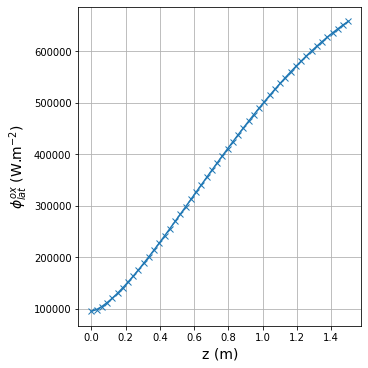

In [147]:
theta_ox = np.arcsin(1-oxide["H"]/R)
cb=8*(1-np.sin(theta_ox))/(3*(math.pi/2 - theta_ox)-3*np.sin(theta_ox)*np.cos(theta_ox)-2*np.sin(theta_ox)*np.cos(theta_ox)**3)
def shapeFunction(z):
    theta = np.arcsin(1-z/R)
    return 0.25 + 0.75*cb*np.cos(theta)**3

# verify that the integral is correct (\int_O^{H^{ox}} f(z) dz = H^{ox})
import scipy.integrate as integrate
integral, error = integrate.quad(shapeFunction, 0, oxide["H"])
print(integral)

z=np.linspace(0,oxide["H"],50)
philat_ox_profile=philat_ox*shapeFunction(z)
plt.rcParams["figure.figsize"] = (5,5)
fig,ax = plt.subplots(constrained_layout=True)
csf = ax.plot(z, philat_ox_profile, marker="x")
ax.set_xlabel("z (m)",fontsize=14)
ax.set_ylabel("$\phi_{lat}^{ox}$ (W.m$^{-2}$)",fontsize=14)
ax.grid(True)

# 2. Refractory crust and vessel wall ablation

In [148]:
vessel = {
      "lambda": 40,
      "e":     0.2,
      "Tfus": 1700,
    }
Tbc=500

Calculate and plot the crust thickness and vessel wall residual thickness as a function of height ($z \in [0,H^{ox}]$)

For any $z$, one can write $\displaystyle T_{c/v}(z) = \frac{e_v(z)}{\lambda_v} \varphi_{lat}^{ox}(z) + T_{lat}^{BC}$

>Assuming that the vessel is not ablated (i.e. $e_v(z)=e_0=0.2$m), one can evaluate $T_{c/v}(z)$

>If $T_{c/v}(z)$ is found greater than $T_{fus}^{vessel}=1650$K, this means that the vessel wall is ablated (i.e. $e_v(z)<e_0$) in such a way that $T_{c/v}(z)=T_{fus}^{vessel}$ and $\displaystyle e_v(z)=\frac{\lambda_v\left(T_{fus}^{vessel}-T_{lat}^{BC}\right)}{\varphi_{lat}^{ox}(z)}$

>From there, for any $z$, both $T_{c/v}(z)$ and $e_v(z)$ are known and the crust thickness is calculated by $\displaystyle e_c(z)=\frac{\lambda_c\left(T_{lat}^{ox}-T_{c/v}(z)\right)}{\varphi_{lat}^{ox}(z)}$

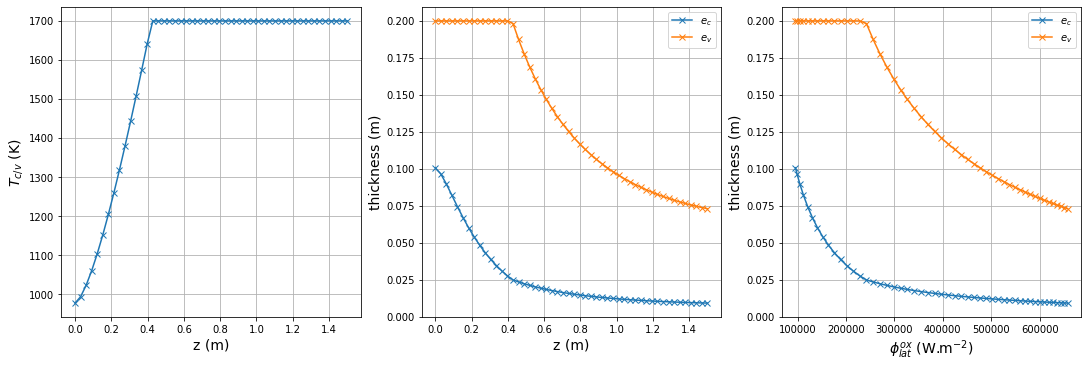

In [149]:
Ti = vessel["e"]/vessel["lambda"]*philat_ox_profile + Tbc
ev = np.full(z.shape, vessel["e"])
for i, T in enumerate(Ti):
    if (T>vessel["Tfus"]):
        Ti[i]=vessel["Tfus"]
        ev[i]=vessel["lambda"]*(Ti[i]-Tbc)/philat_ox_profile[i]
ec = oxide["lambda"]*(oxide["Tliq"]-Ti)/philat_ox_profile
plt.rcParams["figure.figsize"] = (15,5)
fig,axes = plt.subplots(1,3,constrained_layout=True)
ax=axes[0]
csf = ax.plot(z,Ti, marker="x")
ax.set_xlabel("z (m)",fontsize=14)
ax.set_ylabel("$T_{c/v}$ (K)",fontsize=14)
ax.grid(True)
ax=axes[1]
csf = ax.plot(z, ec, marker="x", label="$e_c$")
csf = ax.plot(z, ev, marker="x", label="$e_v$")
ax.set_xlabel("z (m)",fontsize=14)
ax.set_ylabel("thickness (m)",fontsize=14)
ax.grid(True)
ax.legend(loc="best")
ax=axes[2]
csf = ax.plot(philat_ox_profile, ec, marker="x", label="$e_c$")
csf = ax.plot(philat_ox_profile, ev, marker="x", label="$e_v$")
ax.set_xlabel("$\phi_{lat}^{ox}$ (W.m$^{-2}$)",fontsize=14)
ax.set_ylabel("thickness (m)",fontsize=14)
ax.grid(True)
ax.legend(loc="best")

# 3. Metallic pool

Set $\rho^{met},\lambda^{met},\nu^{met},Cp^{met},\beta^{met},T_{liq}^{met},H^{met}$

In [150]:
metal = {
      "rho":    7000,
      "lambda": 25,
      "nu":     5E-7,
      "Cp":     800.0,
      "beta":   1E-4,
      "Tliq":   1700,
      "H":      0.5
    }

Calculate $Pr^{met}$

Define function $Ra^{met}\left[\Delta T\right]$ and evaluate it for $\Delta T=100$K

Shall we expect a turbulent or laminar flow?

>$\alpha^{met}=\frac{\lambda^{met}}{\rho^{met}Cp^{ox}}$

>$Pr^{met}=\frac{\nu^{met}}{\alpha^{met}}$

>$Ra^{met}\left[\Delta T\right]=\frac{g\beta^{met}\left(H^{met}\right)^3 \Delta T}{\nu^{met}\alpha^{met}}$

In [151]:
metal["alpha"]=metal["lambda"]/(metal["rho"]*metal["Cp"])
Pr_met=metal["nu"]/metal["alpha"]
print('Pr_met={0:3.2f}'.format(Pr_met))
RA_met= lambda deltaT: g*metal["beta"]*metal["H"]**3*deltaT/(metal["nu"]*metal["alpha"])
print('Ra_met(100)={0:e}'.format(RA_met(100)))

Pr_met=0.11
Ra_met(100)=5.493600e+09


Calculate $V^{met}$, $S_{lat}^{met}$, $S_{up}^{met}$ (hint: in order to vary $H^{met}$ later on, do such calculations in a function)

In [152]:
def MetalGeometry():
    V_hem = 2*pi/3*R**3
    H_tot = oxide["H"] + metal["H"]
    H_cyl = H_tot - R
    if (H_cyl>=0):
        V_cyl = pi*R**2*H_cyl
        V_met = V_hem - V_ox + V_cyl
        Slat_hem = 2*pi*R*(R-oxide["H"])
        Slat_cyl = 2*pi*R*H_cyl
        Slat_met=Slat_hem + Slat_cyl
        Sup_met=pi*R**2
    else:
        V_met = pi/3*H_tot**2*(3*R-H_tot)-V_ox
        Slat_met=2*pi*R*metal["H"]
        Sup_met=pi*(R**2-(R-H_tot)**2)
    return V_met, Slat_met, Sup_met
V_met, Slat_met, Sup_met = MetalGeometry()
print('V_met={0:e}, Slat_met={1:e}, Sup_met={2:e}'.format(V_met, Slat_met, Sup_met))

V_met=6.152286e+00, Slat_met=6.283185e+00, Sup_met=1.256637e+01


Consider the Globe&Dropkin (resp. turbulent Chawla&Chan) for upward (resp.lateral ) heat transfer and define the following functions:

>$Nu^{met}_{up}\left[\Delta T\right]=0.069\left(Pr^{met}\right)^{0.074}\left(Ra^{met}\left[\Delta T\right]\right)^{1/3}$

>$Nu^{met}_{lat}\left[\Delta T\right]=\frac{0.16}{\left(1+\left(\frac{0.492}{Pr^{met}}\right)^{9/16}\right)^{16/27}}\left(Ra^{met}\left[\Delta T\right]\right)^{1/3}$

In [153]:
NUup_met=lambda DeltaT: 0.069*Pr_met**0.074*RA_met(DeltaT)**(1/3)
NUlat_met=lambda DeltaT: 0.16/(1+(0.492/Pr_met)**(9/16))**(16/27)*RA_met(DeltaT)**(1/3)
PHIup_met=lambda DeltaT: metal["lambda"]/metal["H"]*NUup_met(DeltaT)*DeltaT
PHIlat_met=lambda DeltaT: metal["lambda"]/metal["H"]*NUlat_met(DeltaT)*DeltaT

## 3.1 Adiabatic top boundary condition

Consider an adiabatic boundary at the top of the metal layer <i>i.e.</i> $\phi^{BC}_{up}=0$

Calculate $\phi_{lat}^{met}$

>$\phi_{lat}^{met}=\frac{\phi_{up}^{ox}S_{up}^{ox}}{S_{lat}^{met}}$

In [154]:
philat_met=phiup_ox*Sup_ox/Slat_met
print('philat_met={0:e}, phiup_met={1:e}'.format(philat_met, 0.0))

philat_met=1.241495e+06, phiup_met=0.000000e+00


Calculate $T^{met}$

>$T^{met}=T^{met}_{liq} + \left(\frac{\phi_{lat}^{met}\left(1+\left(\frac{0.492}{Pr^{met}}\right)^{9/16}\right)^{16/27}}{0.16\lambda^{met}}\right)^{3/4} \times \left(\frac{\nu^{met}\alpha^{met}}{g\beta^{met}}\right)^{1/4}$

In [155]:
T_met=metal["Tliq"]+(philat_met/(metal["lambda"] * 0.16/(1+(0.492/Pr_met)**(9/16))**(16/27)))**(3/4)*((metal["nu"]*metal["alpha"])/(g*metal["beta"]))**(1/4)
print('T_met={0:5.1f}'.format(T_met))

T_met=1854.4


## 3.2 Radiative top boundary condition

Consider radiative heat transfer at the top boundary under the simple form $\phi^{BC}_{up}\left[T^{met}_{up}\right]=\varepsilon_{up}\sigma\left(\left(T^{met}_{up}\right)^4-\left(T^{BC}\right)^4\right)$ where $\varepsilon_{up}$ is an "effective emissivity" and define the associated function

In [156]:
PHIrad=lambda Ti: emissivity*sigma*(Ti**4-Tsurroundings**4)

Implement an algorithm in order to find $\left(T^{met},T_{up}^{met}\right)$.

$\left\{\begin{array}{rcl}
S_{up}^{ox}\phi_{lat}^{ox} &=& S_{lat}^{met}\phi_{lat}^{met}\left[T^{met}-T_{liq}^{met}\right]+S_{up}^{met}\phi_{up}^{met}\left[T^{met}-T_{up}^{met}\right] \\
\phi_{up}^{BC}\left[T_{up}^{met}\right] &=& \phi_{up}^{met}\left[T^{met}-T_{up}^{met}\right]
\end{array}\right.$

In [157]:
from scipy.optimize import brentq

def FluxBalanceUp(T,Ti):
    return PHIup_met(T-Ti) - PHIrad(Ti)

def PowerBalance(T):
    Tup=brentq(lambda Ti : FluxBalanceUp(T,Ti), Tsurroundings, T)
    return phiup_ox*Sup_ox-Sup_met*PHIup_met(T-Tup)-Slat_met*PHIlat_met(T-metal["Tliq"])
    
def MetalPowerBalance():
    T_met=brentq(PowerBalance, metal["Tliq"], metal["Tliq"]+2000.0)
    Tup_met=brentq(lambda Ti : FluxBalanceUp(T_met,Ti), Tsurroundings, T_met)
    philat_met=PHIlat_met(T_met-metal["Tliq"])
    phiup_met=PHIup_met(T_met-Tup_met)
    return T_met,Tup_met,philat_met,phiup_met

Calculate $\left(T^{met},T_{up}^{met},\phi_{lat}^{met},\phi_{up}^{met}\right)$ for $\varepsilon_{up} = 0.4$ and $T^{BC}=1000$K

In [158]:
Tsurroundings=1000
emissivity=0.4

In [159]:
(T_met,Tup_met,philat_met,phiup_met) = MetalPowerBalance()
print('T_met={0:5.1f}, Tup_met={1:5.1f}'.format(T_met,Tup_met))
print('philat_met={0:e}, phiup_met={1:e}'.format(philat_met, phiup_met))
print('power partition lat={0:3.2f}%, up={1:3.2f}%'.format(philat_met*Slat_met/(phiup_ox*Sup_ox)*100, phiup_met*Sup_met/(phiup_ox*Sup_ox)*100))

T_met=1815.6, Tup_met=1766.9
philat_met=8.447110e+05, phiup_met=1.983919e+05
power partition lat=68.04%, up=31.96%


## 3.3 Parametric studies

### Varying $\varepsilon_{up}$ and $T^{BC}$

In [160]:
emissivity_narray=np.linspace(0.0, 1.0, num=21)
Tsurroundings_narray=np.linspace(950, metal["Tliq"], num=21)
emissivity_grid,Tsurroundings_grid=np.meshgrid(emissivity_narray,Tsurroundings_narray)
iterator_grid=np.nditer([emissivity_grid,Tsurroundings_grid,None,None,None,None])
with iterator_grid:
    for emissivity,Tsurroundings,T_met_grid,Tup_met_grid,philat_met_grid,phiup_met_grid in iterator_grid:
        #print('emissivity={0:3.2f}, Tsurroundings={1:5.1e}'.format(emissivity,T_met_grid))
        (T_met_grid[...],Tup_met_grid[...],philat_met_grid[...],phiup_met_grid[...]) = MetalPowerBalance()
    T_met_grid=iterator_grid.operands[2]
    Tup_met_grid=iterator_grid.operands[3]
    philat_met_grid=iterator_grid.operands[4]
    phiup_met_grid=iterator_grid.operands[5]

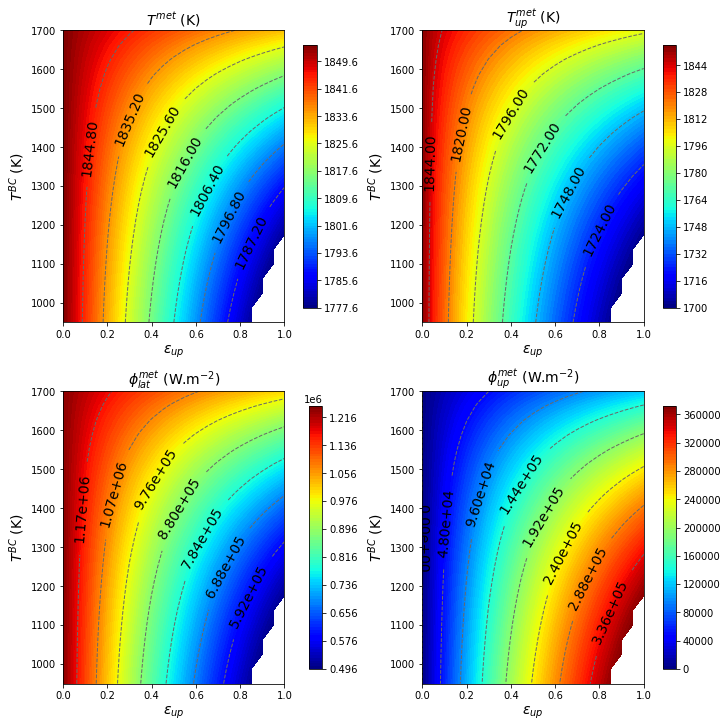

In [161]:
nonadmissible = Tup_met_grid<metal["Tliq"]

def MyContourPlot(ax,x,y,z,xlabel,ylabel,zlabel,format):
    z[nonadmissible] = np.nan
    csf = ax.contourf(x,y,z, 100, cmap='jet')
    fig.colorbar(csf, ax=ax, shrink=0.9)
    cs = ax.contour(csf, levels=csf.levels[::12], colors=('dimgray',),linewidths=(1,),linestyles=('dashed',))
    ax.clabel(cs, fmt=format, colors='k', fontsize=14)
    ax.set_title(zlabel,fontsize=14)
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    

plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(2,2,constrained_layout=True)
MyContourPlot(ax[0,0],emissivity_grid,Tsurroundings_grid,T_met_grid,'$\epsilon_{up}$','$T^{BC}$ (K)','$T^{met}$ (K)','%3.2f')
MyContourPlot(ax[0,1],emissivity_grid,Tsurroundings_grid,Tup_met_grid,'$\epsilon_{up}$','$T^{BC}$ (K)','$T^{met}_{up}$ (K)','%3.2f')
MyContourPlot(ax[1,0],emissivity_grid,Tsurroundings_grid,philat_met_grid,'$\epsilon_{up}$','$T^{BC}$ (K)','$\phi^{met}_{lat}$ (W.m$^{-2}$)','%3.2e')
MyContourPlot(ax[1,1],emissivity_grid,Tsurroundings_grid,phiup_met_grid,'$\epsilon_{up}$','$T^{BC}$ (K)','$\phi^{met}_{up}$ (W.m$^{-2}$)','%3.2e')
plt.savefig("Varying_Emissivity_TBC_1.eps")

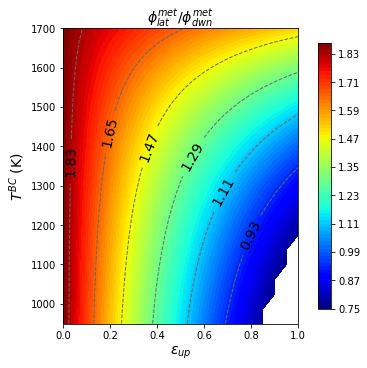

In [162]:
plt.rcParams["figure.figsize"] = (5,5)
fig,ax = plt.subplots(constrained_layout=True)
MyContourPlot(ax,emissivity_grid,Tsurroundings_grid,philat_met_grid/phiup_ox,'$\epsilon_{up}$','$T^{BC}$ (K)','$\phi^{met}_{lat}/\phi^{met}_{dwn}$','%3.2f')
plt.savefig("Varying_Emissivity_TBC_2.eps")

### Varying $H^{met}$

In [163]:
emissivity=0.38
Tsurroundings=950
Hmet_narray=np.linspace(0.01, 0.5, num=50)
iterator_grid=np.nditer([Hmet_narray,None,None,None,None])
with iterator_grid:
    for Hmet,T_met_grid,Tup_met_grid,philat_met_grid,phiup_met_grid in iterator_grid:
        metal["H"]=Hmet
        (V_met, Slat_met, Sup_met) = MetalGeometry()
        (T_met_grid[...],Tup_met_grid[...],philat_met_grid[...],phiup_met_grid[...]) = MetalPowerBalance()
    T_met_grid=iterator_grid.operands[1]
    Tup_met_grid=iterator_grid.operands[2]
    philat_met_grid=iterator_grid.operands[3]
    phiup_met_grid=iterator_grid.operands[4]

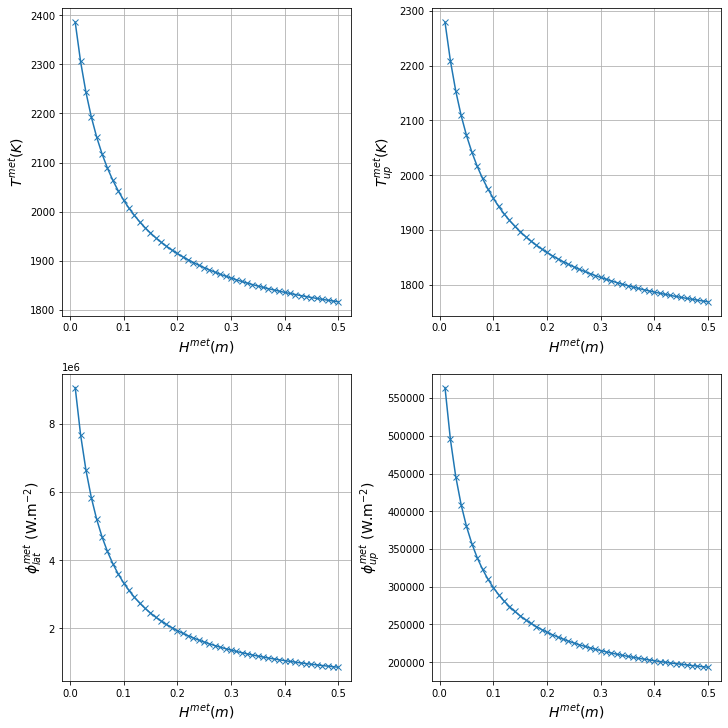

In [164]:
nonadmissible = Tup_met_grid<metal["Tliq"]

def MyXYPlot(ax,x,y,xlabel,ylabel):
    y[nonadmissible] = np.nan
    csf = ax.plot(x,y, marker="x")
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    ax.grid(True)
    
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(2,2,constrained_layout=True)
MyXYPlot(ax[0,0],Hmet_narray,T_met_grid,'$H^{met} (m)$','$T^{met} (K)$')
MyXYPlot(ax[0,1],Hmet_narray,Tup_met_grid,'$H^{met} (m)$','$T^{met}_{up} (K)$')
MyXYPlot(ax[1,0],Hmet_narray,philat_met_grid,'$H^{met} (m)$','$\phi^{met}_{lat}$ (W.m$^{-2}$)')
MyXYPlot(ax[1,1],Hmet_narray,phiup_met_grid,'$H^{met} (m)$','$\phi^{met}_{up}$ (W.m$^{-2}$)')

plt.savefig("Varying_Hmet_1.eps")

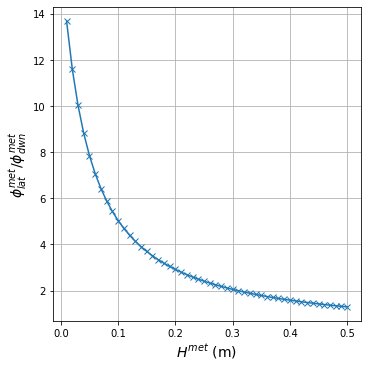

In [165]:
plt.rcParams["figure.figsize"] = (5,5)
fig,ax = plt.subplots(constrained_layout=True)
MyXYPlot(ax,Hmet_narray,philat_met_grid/phiup_ox,'$H^{met}$ (m)','$\phi^{met}_{lat}/\phi^{met}_{dwn}$')
plt.savefig("Varying_Hmet_2.eps")

# Saving python script for use out of Jupyter

In [166]:
!/home/rl211391/.local/bin/jupyter nbconvert --to script TD.ipynb
!/home/rl211391/.local/bin/jupyter nbconvert --to PDF TD.ipynb

[NbConvertApp] Converting notebook TD.ipynb to script
[NbConvertApp] Writing 16816 bytes to TD.py
[NbConvertApp] Converting notebook TD.ipynb to PDF
[NbConvertApp] Support files will be in TD_files/
[NbConvertApp] Making directory ./TD_files
[NbConvertApp] Making directory ./TD_files
[NbConvertApp] Making directory ./TD_files
[NbConvertApp] Making directory ./TD_files
[NbConvertApp] Making directory ./TD_files
[NbConvertApp] Making directory ./TD_files
[NbConvertApp] Writing 88404 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 402242 bytes to TD.pdf


# Some other calculations for the lecture

In [167]:
D=5E-9

metal["H"]=5E-2
deltaT=100
Sc=metal["alpha"]/D
Ra=RA_met(deltaT)
Pr=Pr_met
Gr=Ra/Pr
Nu=NUup_met(deltaT)
ShOverNu=Gr**(1/12)*Sc**(1/3)*Pr**(-1/3)
Sh=ShOverNu*Nu
print('Gr={0:4.3e}, Nu={1:4.3e}, Sh/Nu={2:4.3e}, Sh={3:4.3e}'.format(Gr,Nu,ShOverNu,Sh))

L=metal["H"]
tau_heat=L**2/metal["alpha"]/Nu
tau_mass=L**2/D/Sh
print('tau(heat)={0:4.3e}, tau(mass)={1:4.3e}'.format(tau_heat,tau_mass))

# RCW
oxide["H"]=0.2
S=pi*0.09**2
V_ox = S*oxide["H"]
q_ox = 20E3 / V_ox
Sc=oxide["alpha"]/D
Ra=g*oxide["H"]**5*q_ox*oxide["beta"]/(oxide["lambda"]*oxide["nu"]*oxide["alpha"])
Nu=0.381*Ra**0.234
Pr=oxide["nu"]/oxide["alpha"]
Gr=Ra/(Pr*Nu)
ShOverNu=Gr**(1/12)*Sc**(1/3)*Pr**(-1/3)
Sh=ShOverNu*Nu
print('Gr={0:4.3e}, Nu={1:4.3e}, Sh/Nu={2:4.3e}, Sh={3:4.3e}'.format(Gr,Nu,ShOverNu,Sh))
L=oxide["H"]
tau_heat=L**2/oxide["alpha"]/Nu
tau_mass=L**2/D/Sh
print('tau(heat)={0:4.3e}, tau(mass)={1:4.3e}'.format(tau_heat,tau_mass))

Gr=4.905e+07, Nu=1.035e+01, Sh/Nu=8.738e+01, Sh=9.047e+02
tau(heat)=5.409e+01, tau(mass)=5.527e+02
Gr=5.010e+09, Nu=1.970e+02, Sh/Nu=5.499e+01, Sh=1.083e+04
tau(heat)=1.624e+02, tau(mass)=7.385e+02
